In [1]:
import pandas as pd
import os, sys
from pathlib import Path

sys.path.append('../src/')

from main.classifier_cost_benefit_calculator import net_gain_curve, plot_net_gain_curve

# Load data

For this tutorial we use the credit card fraud detection dataset (downloaded from https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud): 

In [9]:
df_undspl = pd.read_csv('data/creditcard_undersampled.csv').drop('Unnamed: 0', axis=1)

The original dataset is highly imbalanced: for the sake of simplicity we had undersampled the dataset in order to have a 66/33 ratio between class 0 (genuine transaction) and class 1 (fradulent transaction)

In [10]:
df_undspl.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1
1,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1
2,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1
3,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,...,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1
4,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,...,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1


In [5]:
df_undspl.Class.describe()

count    1476.000000
mean        0.333333
std         0.471564
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: Class, dtype: float64

# Data preparation 

Split the dataset into features and target, and into training and test:

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X, y = df_undspl.drop('Class', axis=1), df_undspl['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [8]:
X_train.shape

(988, 30)

In [9]:
X_test.shape

(488, 30)

# Model training 

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [11]:
rf = RandomForestClassifier()
lr = LogisticRegression()
tree = DecisionTreeClassifier()

In [12]:
tree = tree.fit(X_train, y_train)
lr = lr.fit(X_train, y_train)
rf = rf.fit(X_train, y_train)

### Performance on test set 

In [13]:
from sklearn.metrics import roc_auc_score, average_precision_score, recall_score

In [14]:
y_score_rf = [i[1] for i in rf.predict_proba(X_test)]
y_score_tree = [i[1] for i in tree.predict_proba(X_test)]
y_score_lr = [i[1] for i in lr.predict_proba(X_test)]

In [15]:
roc_auc_score(y_test.values, y_score_lr)

0.940796493902439

In [16]:
average_precision_score(y_test.values, y_score_lr)

0.9370802080433185

In [17]:
recall_score(y_test.values, [1 if i > 0.5 else 0 for i in y_score_lr])

0.85625

## What cut-off should we use for the classifier?

#### Case 1: cost of false positive much smaller than gain for true positive 

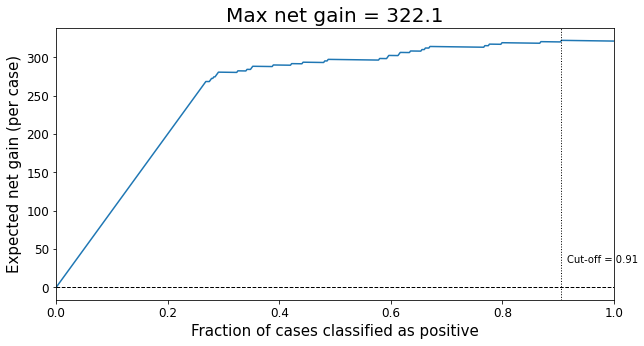

In [21]:
tp_gain = 1000.
fp_cost = 10.

expected_net_gain_series_lr, expected_net_gain_max_lr, optimal_threshold_lr = \
    net_gain_curve(y_test, y_score_lr, tp_gain, fp_cost)

plot_net_gain_curve(expected_net_gain_series_lr,figsize=(10,5))

#### Case 2: cost for false positive ~= gain for true positive 

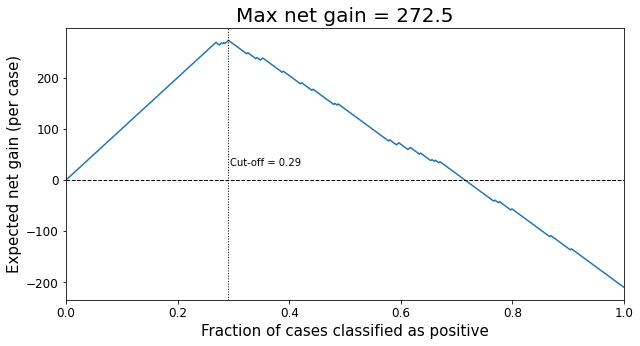

In [24]:
tp_gain = 1000.
fp_cost = 800.

expected_net_gain_series_lr, expected_net_gain_max_lr, optimal_threshold_lr = \
    net_gain_curve(y_test, y_score_lr, tp_gain, fp_cost)

plot_net_gain_curve(expected_net_gain_series_lr,figsize=(10,5))

#### Case 3: cost for false positive >> gain for true positive 

Text(0.2711270491803279, 2.6844262295081966, 'Cut-off = 0.3')

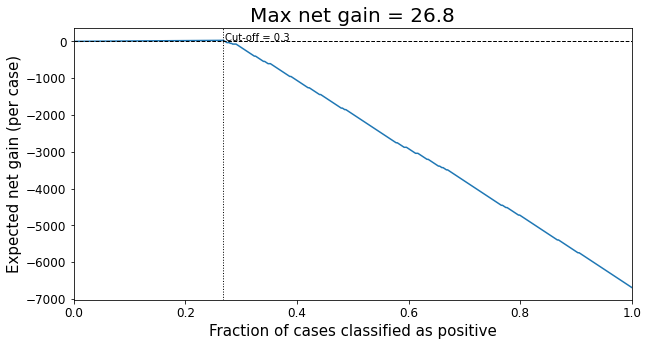

In [27]:
tp_gain = 100.
fp_cost = 10000.

expected_net_gain_series_lr, expected_net_gain_max_lr, optimal_threshold_lr = \
    net_gain_curve(y_test, y_score_lr, tp_gain, fp_cost)

fig,ax = plt.subplots(1,1,figsize=(10,5))

expected_net_gain_series_lr.plot(ax=ax,fontsize=12)
ax.axhline(y=0, c='black', linestyle='--', linewidth=1)
ax.axvline(x=expected_net_gain_series_lr.idxmax(), c='black', linestyle=':', linewidth=1)

ax.set_xlim([0., 1.])
ax.set_xlabel("Fraction of cases classified as positive",fontsize=15)
ax.set_ylabel("Expected net gain (per case)",fontsize=15)
ax.set_title(f'Max net gain = {round(expected_net_gain_series_lr.max(),1)}', fontsize=20)
ax.annotate(f'Cut-off = {round(expected_net_gain_series_lr.idxmax(),1)}',
            (expected_net_gain_series_lr.idxmax()+expected_net_gain_series_lr.idxmax()*0.01,
             expected_net_gain_series_lr.max()*0.1))

#### Case 4: cost for false positive ~= gain for true positive, but expected prior of class 1 is lower than in the test set (0.1 vs 0.32 in test set)

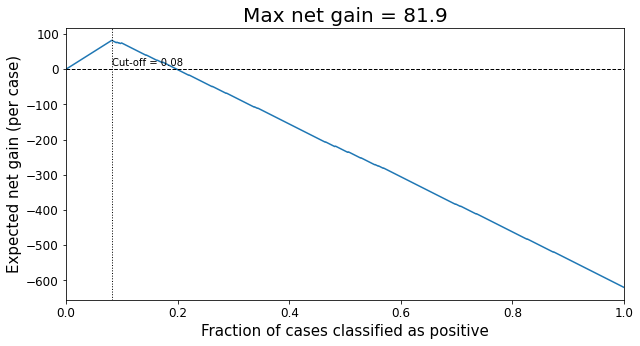

In [28]:
tp_gain = 1000.
fp_cost = 800.
p_1 = 0.1

expected_net_gain_series_lr, expected_net_gain_max_lr, optimal_threshold_lr = \
    net_gain_curve(y_test, y_score_lr, tp_gain, fp_cost, p_1=p_1)

plot_net_gain_curve(expected_net_gain_series_lr,figsize=(10,5))